- Created: 2018-11-09
- Last modified: 2018-12-08 (Duplicated to test for a different param)
- Author: Hsuan-lin Her

- Purpose: To estimate log likelihood score(LLS) for refseq-quantile predicted gene pairs


- Steps
    1. Representing genes in our pan-genome was `diamond blastp REP_GENES --db REFSEQ_GENOMEMS`
    2. e-value was extracted and then transformed
    3. transformed evalue of **all** rep_genes-refseq-genes were taken together, "quantile" `qcut` into 100 pieces
    4. mutual info was calclated between pairs of rep_genes
    5. joined with goldstandard **any GO term sharing**
    6. All pairs with GO term (True/False) labelled were extracted for evaluation and LLS calculation

In [14]:
test_data = '/home/hermuba/data0118/goldstandard_context/refseq_quantile_mu_not_null_all.csv'


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
def to_df(fname):
    '''
    input: .csv containing labelled gene interaction
    output: dataframe
    '''
    d = pd.read_csv(fname, header = 0, nrows = 600000)
    d['goldstandard'] = d['goldstandard'].map({'f':False, 't':True})
    return(d)
def return_stats(d):
    '''
    input: dataframe from `to_df`
    output: stats representing true and false interacting pairs
    '''
    
    d.boxplot(column = ['mutual_info', 'nrm_mutual'], by = 'goldstandard')
    group_d = d.groupby(by = 'goldstandard')
    
    return(group_d[['mutual_info', 'nrm_mutual']].describe())
def kde_d(d):
    
    group_d = d.groupby(by = 'goldstandard')
    plt.subplot(211)
    group_d['mutual_info'].plot(kind = 'kde', legend = True, title = 'mutual')
    plt.subplot(212)
    group_d['nrm_mutual'].plot(kind = 'kde', legend = True, title = 'normalized_mutual')

def LLS(d, score):
    # seperate mutual info score into 100 categories
    d['cut_mutual'] = pd.cut(d[score], 100)
    grouped = d.groupby(by = ['goldstandard', 'cut_mutual']).count()['gene_one']
    lls = grouped[True]/grouped[False]/(grouped[True].sum()/grouped[False].sum())
    lls.plot()
    return(lls)


In [16]:
d = to_df(test_data)

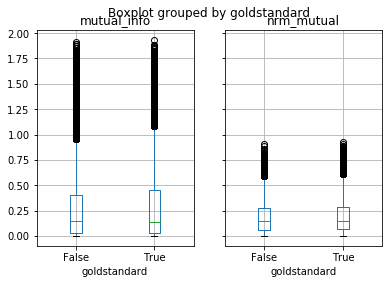

In [17]:
stat_d = return_stats(d)

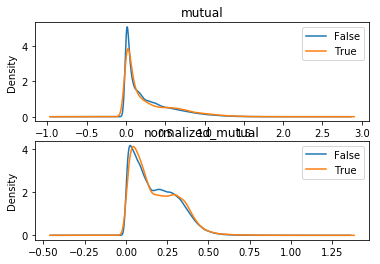

In [18]:
kde_d(d)

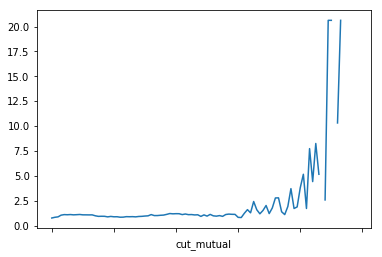

In [19]:
lls = LLS(d, 'nrm_mutual') # very poor

Text(0, 0.5, 'Log-likelihood Score(LLS)')

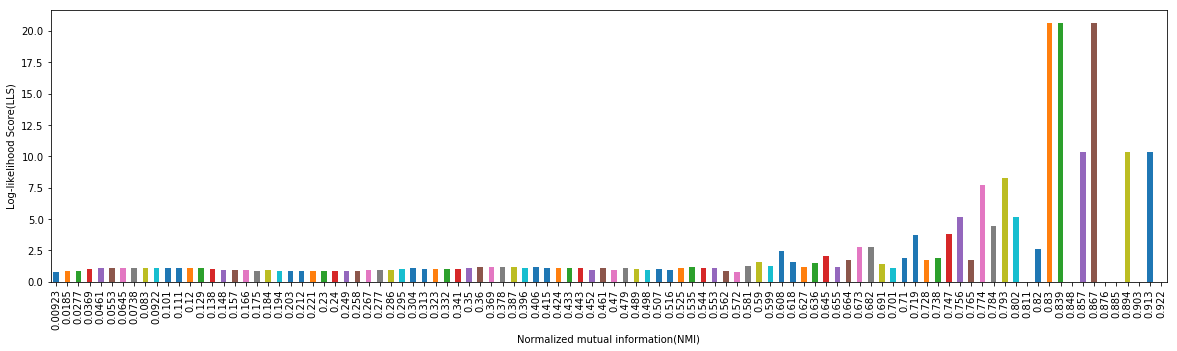

In [20]:
ticks = [i.right for i in lls.index]
ax = lls.plot(use_index = True, kind = 'bar', figsize = (20,5))
ax.set_xticklabels(ticks)
ax.set_xlabel('Normalized mutual information(NMI)')
ax.set_ylabel('Log-likelihood Score(LLS)')

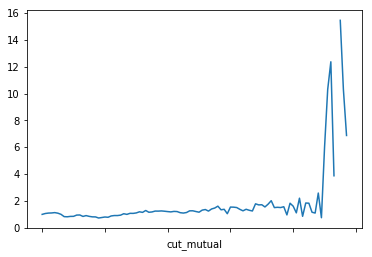

In [21]:
lls = LLS(d, 'mutual_info') #better

Text(0, 0.5, 'Log-likelihood Score(LLS)')

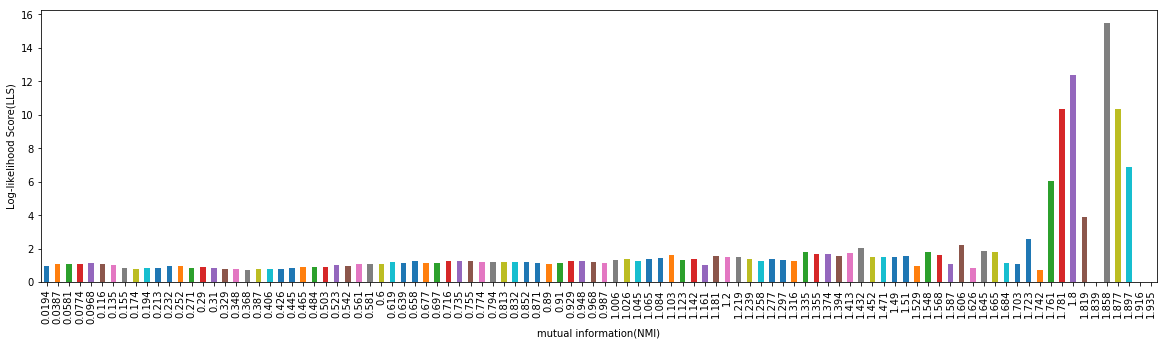

In [22]:
ticks = [i.right for i in lls.index]
ax = lls.plot(use_index = True, kind = 'bar', figsize = (20,5))
ax.set_xticklabels(ticks)
ax.set_xlabel('mutual information(NMI)')
ax.set_ylabel('Log-likelihood Score(LLS)')

# Interpretation
1. The result is still not good enough
2. Caught a bug in `Genome.context.discretise.quantile` => fixed, this bug causes transformed e-value 1 be mapped to 0; but it should be mapped to 99

# Plan
1. Testing the whole set of data is too slow. 
- delete the wrong table in postgre db hermuba refseq_quantile_mu
- use hierachial clustering/t-SNE or other visualization to have a glance
- speed up the mutual_info program
- consider sampling for optimization
